# Time-Series MIA Example 

In [ ]:
import os, sys, yaml, numpy as np, matplotlib.pyplot as plt, torch, random

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(project_root)

from examples.mia.time_series_mia.utils.data_preparation import preprocess_ECG_dataset, preprocess_EEG_dataset, preprocess_LCL_dataset, get_dataloaders
from examples.mia.time_series_mia.utils.model_preparation import create_trained_model_and_metadata, evaluate
from examples.mia.time_series_mia.utils.models.LSTM import LSTM
from examples.mia.time_series_mia.utils.models.TCN import TCN
from examples.mia.time_series_mia.utils.models.DLinear import DLinear
from examples.mia.time_series_mia.utils.models.NBeats import NBeats
from examples.mia.time_series_mia.utils.models.WaveNet import WaveNet

In [2]:
audit_config_path = "audit.yaml"
train_config_path = "train_config.yaml"

# Load the yaml files
with open(audit_config_path, 'r') as file:
    audit_config = yaml.safe_load(file)

with open(train_config_path, 'r') as file:
    train_config = yaml.safe_load(file)

In [ ]:
random_seed = train_config["run"]["random_seed"]
log_dir = train_config["run"]["log_dir"]

epochs = train_config["train"]["epochs"]
batch_size = train_config["train"]["batch_size"]
optimizer = train_config["train"]["optimizer"]

lookback = train_config["data"]["lookback"]
horizon = train_config["data"]["horizon"]
num_individuals = train_config["data"]["num_individuals"]
train_fraction = train_config["data"]["f_train"]
test_fraction = train_config["data"]["f_test"]
dataset = train_config["data"]["dataset"]
data_dir = train_config["data"]["data_dir"]
stride = train_config["data"]["stride"]
k_lead = train_config["data"]["k_lead"] # number of leading variables to use

In [4]:
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [5]:
# Get data loaders
path = os.path.join(os.getcwd(), data_dir)
target_data_file = audit_config["target"]["data_path"].split('/')[-1]

if dataset == 'ECG' and target_data_file == 'ECG.pkl':
    dataset = preprocess_ECG_dataset(path, lookback, horizon, num_individuals, k_lead=k_lead, stride=stride)
elif dataset == 'EEG' and target_data_file == 'EEG.pkl':
    dataset = preprocess_EEG_dataset(path, lookback, horizon, num_individuals, k_lead=k_lead, stride=stride)
elif dataset == 'LCL' and target_data_file == 'LCL.pkl':
    dataset = preprocess_LCL_dataset(path, lookback, horizon, num_individuals, stride=stride)
else:
    raise Exception(f"Received unknown dataset or mismatching target file: dataset={dataset}, target={target_data_file}.")

train_loader, test_loader = get_dataloaders(dataset, train_fraction, test_fraction, batch_size=batch_size)

In [ ]:
# Train the model
input_dim = dataset.input_dim
model_name = audit_config["target"]["model_class"]

if model_name == "LSTM":
    model = LSTM(input_dim, horizon)
elif model_name == "TCN":
    model = TCN(input_dim, horizon)
elif model_name == "DLinear":
    model = DLinear(input_dim, lookback, horizon)
elif model_name == "NBeats":
    model = NBeats(input_dim, lookback, horizon)
elif model_name == "WaveNet":
    model = WaveNet(input_dim, horizon)
else:
    raise NotImplementedError()

train_loss, test_loss = create_trained_model_and_metadata(model, train_loader, test_loader, epochs, optimizer)

Training Progress: 100%|██████████| 100/100 [01:27<00:00,  1.15it/s]


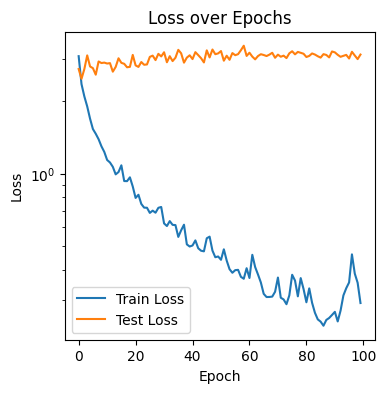

In [7]:
# Plot training and test loss
plt.figure(figsize=(4, 4))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

In [8]:
# Print final loss and unscaled MSE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f'Final train loss: {train_loss[-1]}')
print(f'Final test loss: {test_loss[-1]}')
print(f'Final train MSE (unscaled): {evaluate(model, train_loader, torch.nn.MSELoss(), device, original_scale=True)}')
print(f'Final test MSE (unscaled): {evaluate(model, test_loader, torch.nn.MSELoss(), device, original_scale=True)}')

Final train loss: 0.2907999042293121
Final test loss: 3.1333551578994454
Final train MSE (unscaled): 1596.490482724946
Final test MSE (unscaled): 18577.663150129647


### Plotting sample predictions

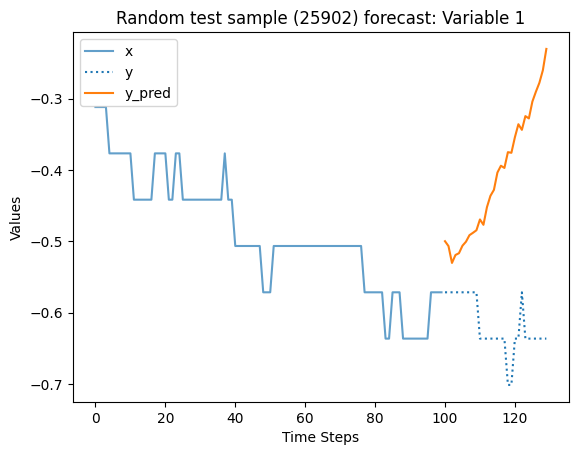

In [9]:
# Get random sample (re-execute for new one)
indices = test_loader.dataset.indices
random_sample_idx = np.random.choice(indices)
x = dataset.x[random_sample_idx,:,:].to(device)
y = dataset.y[random_sample_idx,:,:]
y_pred = model(x.unsqueeze(0)).detach().squeeze(0)

# Time axis
time_x = np.arange(lookback)
time_y = np.arange(lookback, lookback + horizon)

for i in range(y.shape[-1]):  # plot forecast for each variable in the series
    plt.plot(time_x, x[:, i].cpu().numpy(), label='x', alpha=0.7)  # lookback
    plt.plot(time_y, y[:, i], label='y', color='C0', linestyle='dotted')  # true horizon
    plt.plot(time_y, y_pred[:, i].cpu().numpy(), label='y_pred', color='C1')  # prediction

    plt.xlabel("Time Steps")
    plt.ylabel("Values")
    plt.legend()
    plt.title(f"Random test sample ({random_sample_idx}) forecast: Variable {i+1}")
    plt.show()

### Running MIA

In [13]:
from data_handler import IndividualizedInputHandler
from leakpro import LeakPro

# Prepare leakpro object
leakpro = LeakPro(IndividualizedInputHandler, audit_config_path)

# Run the audit 
leakpro.run_audit()

2025-03-05 13:23:30,239 INFO     Target model blueprint created from NBeats in ./utils/models/NBeats.py.
2025-03-05 13:23:30,241 INFO     Loaded target model metadata from ./target/model_metadata.pkl
2025-03-05 13:23:30,253 INFO     Loaded target model from ./target
2025-03-05 13:23:30,356 INFO     Loaded population dataset from ../../../../data/ECG.pkl
2025-03-05 13:23:30,357 INFO     Loaded population dataset from ../../../../data/ECG.pkl
2025-03-05 13:23:30,357 INFO     MIA attack factory loaded.
2025-03-05 13:23:30,358 INFO     Added attack: lira
2025-03-05 13:23:30,359 INFO     Preparing attack: lira
2025-03-05 13:23:30,364 WARNING  Using the same model class for shadow models as the target model.
2025-03-05 13:23:30,385 INFO     Number of existing models exceeds or equals the number of models to create
2025-03-05 13:23:30,385 INFO     Loading shadow model 25
2025-03-05 13:23:30,394 INFO     Loaded model from ./leakpro_output/attack_objects/shadow_model/shadow_model_25.pkl
2025-03

{'audit': {'random_seed': 42, 'attack_list': {'lira': {'training_data_fraction': 0.3, 'num_shadow_models': 64, 'var_calculation': 'individual_carlini', 'online': True, 'signal': 'MSELoss', 'eval_batch_size': 512}}, 'output_dir': './leakpro_output', 'attack_type': 'mia', 'modality': 'time_series'}, 'target': {'module_path': './utils/models/NBeats.py', 'model_class': 'NBeats', 'target_folder': './target', 'data_path': '../../../../data/ECG.pkl'}, 'shadow_model': None, 'distillation_model': None}


2025-03-05 13:23:30,446 INFO     Loaded model from ./leakpro_output/attack_objects/shadow_model/shadow_model_41.pkl
2025-03-05 13:23:30,446 INFO     Loading shadow model 33
2025-03-05 13:23:30,454 INFO     Loaded model from ./leakpro_output/attack_objects/shadow_model/shadow_model_33.pkl
2025-03-05 13:23:30,455 INFO     Loading shadow model 21
2025-03-05 13:23:30,462 INFO     Loaded model from ./leakpro_output/attack_objects/shadow_model/shadow_model_21.pkl
2025-03-05 13:23:30,463 INFO     Loading shadow model 38
2025-03-05 13:23:30,471 INFO     Loaded model from ./leakpro_output/attack_objects/shadow_model/shadow_model_38.pkl
2025-03-05 13:23:30,471 INFO     Loading shadow model 14
2025-03-05 13:23:30,479 INFO     Loaded model from ./leakpro_output/attack_objects/shadow_model/shadow_model_14.pkl
2025-03-05 13:23:30,480 INFO     Loading shadow model 9
2025-03-05 13:23:30,489 INFO     Loaded model from ./leakpro_output/attack_objects/shadow_model/shadow_model_9.pkl
2025-03-05 13:23:30,4

<Figure size 640x480 with 0 Axes>